GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

## Editted by @fujiisoup

In this note, I checked the updated umplementation where the model reuse with different data becomes possible.

Please see

model.update_data(X,Y)
gpr.update_data(X,Y)
vgp.update_data(X,Y)

In [1]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


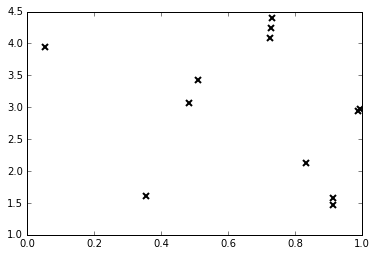

In [2]:
# build a very simple data set:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

Maximum Likelihood estimation
--

In [3]:
#build the GPR object
k = GPflow.kernels.Matern52(1)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

In [4]:
print "Here are the parameters before optimization"
m

Here are the parameters before optimization


Name,values,prior,constraint
model.mean_function.A,[[ 1.]],None,(none)
model.mean_function.b,[ 0.],None,(none)
model.kern.variance,[ 1.],None,+ve
model.kern.lengthscales,[ 1.],None,+ve
model.likelihood.variance,[ 0.01],None,+ve


In [5]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.58887887001  (s) for compilation and optimization


Name,values,prior,constraint
model.mean_function.A,[[-0.89213723]],None,(none)
model.mean_function.b,[ 3.39535998],None,(none)
model.kern.variance,[ 0.88145102],None,+ve
model.kern.lengthscales,[ 0.03325801],None,+ve
model.likelihood.variance,[ 0.00403686],None,+ve


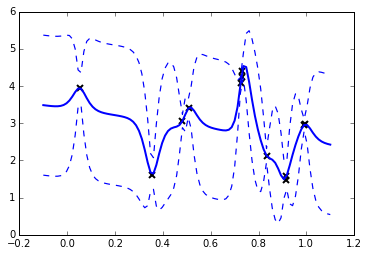

In [6]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### For another data

In [7]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
# update data
m.update_data(X, Y)

In [8]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization
0.163536071777  (s) for optimization


Name,values,prior,constraint
model.mean_function.A,[[-0.37796845]],None,(none)
model.mean_function.b,[ 3.33905034],None,(none)
model.kern.variance,[ 0.53934306],None,+ve
model.kern.lengthscales,[ 0.08973647],None,+ve
model.likelihood.variance,[ 5.69699843e-12],None,+ve


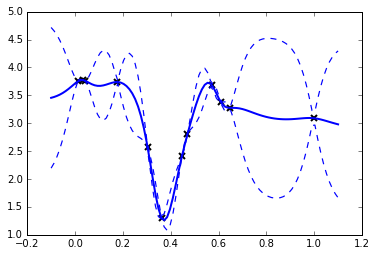

In [9]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### For another data with different shape

In [10]:
# shape changed!
N = 13
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
# update data
m.update_data(X, Y)

In [11]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.677676916122  (s) for compilation and optimization


Name,values,prior,constraint
model.mean_function.A,[[ 0.4247835]],None,(none)
model.mean_function.b,[ 3.23159819],None,(none)
model.kern.variance,[ 0.48830325],None,+ve
model.kern.lengthscales,[ 0.03663643],None,+ve
model.likelihood.variance,[ 5.69699843e-12],None,+ve


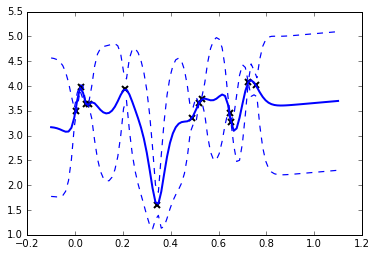

In [12]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

## Fixing the parameters

In [13]:
# Fix the lengthscale
m.kern.lengthscales.fixed = True
m.kern.lengthscales = np.array([0.1,]).reshape(-1,1)

In [15]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.554744005203  (s) for compilation and optimization


Name,values,prior,constraint
model.mean_function.A,[[ 1.65746932]],None,(none)
model.mean_function.b,[ 2.44849676],None,(none)
model.kern.variance,[ 6.2938172],None,+ve
model.kern.lengthscales,[ 0.1],None,[FIXED]
model.likelihood.variance,[ 5.69699843e-12],None,+ve


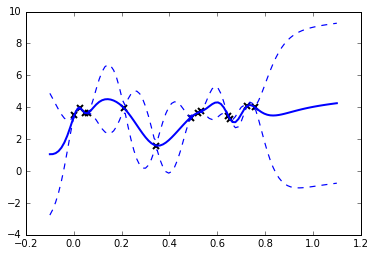

In [16]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### With different value for fixed param

In [17]:
# Fix the lengthscale
m.kern.lengthscales = np.array([0.2,]).reshape(-1,1)

In [18]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization
0.127955913544  (s) for optimization


Name,values,prior,constraint
model.mean_function.A,[[ 6.4262742]],None,(none)
model.mean_function.b,[-1.37056118],None,(none)
model.kern.variance,[ 126.14795648],None,+ve
model.kern.lengthscales,[ 0.2],None,[FIXED]
model.likelihood.variance,[ 5.69744252e-12],None,+ve


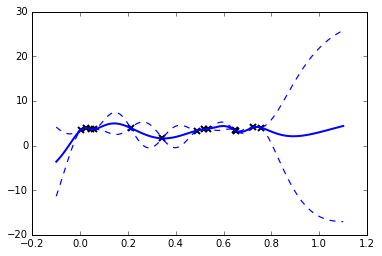

In [19]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

## Variational inference

In [42]:
# shape changed!
N = 13
X = np.random.rand(N,1)
Y = np.abs(np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3)
# update data
m.update_data(X, Y)

In [43]:
#build the GPR object
k = GPflow.kernels.RBF(1)
lik = GPflow.likelihoods.Poisson()
m = GPflow.vgp.VGP(X, Y, k, mean_function=meanf, likelihood=lik)
m.likelihood.variance = 0.01

In [45]:
t = time.time()
m.optimize()
print time.time() - t, " (s) for compilation and optimization" 

optimization terminated, setting model state
0.00714302062988  (s) for compilation and optimization


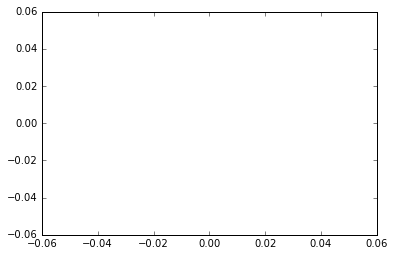

In [46]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
#plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

In [47]:
mean

array([[ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ inf],
       [ i

MCMC
--
First, we'll set come priors on the kernel parameters, then we'll run mcmc and see how much posterior uncertainty there is in the parameters.

In [22]:
m.kern.lengthscales.fixed = False

In [23]:
#we'll choose rather arbitrary priors. 
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constraint
model.mean_function.A,[[ 6.4262742]],"N([ 0.],[ 10.])",(none)
model.mean_function.b,[-1.37056118],"N([ 0.],[ 10.])",(none)
model.kern.variance,[ 126.14795648],"Ga([ 1.],[ 1.])",+ve
model.kern.lengthscales,[ 0.2],"Ga([ 1.],[ 1.])",+ve
model.likelihood.variance,[ 5.69744252e-12],"Ga([ 1.],[ 1.])",+ve


In [24]:
samples = m.sample(500, epsilon = 0.1, verbose=1)

compiling tensorflow function...
done


/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/GPflow-0.1.4-py2.7.egg/GPflow/hmc.py:97: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/GPflow-0.1.4-py2.7.egg/GPflow/hmc.py:101: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  99.0 %
Iteration:  500 	 Acc Rate:  100.0 %


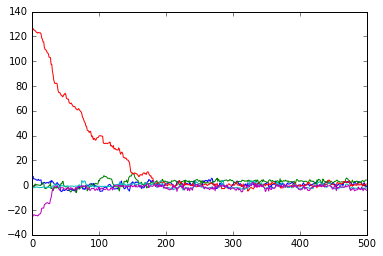

In [25]:
plt.figure()
plt.plot(samples)

/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


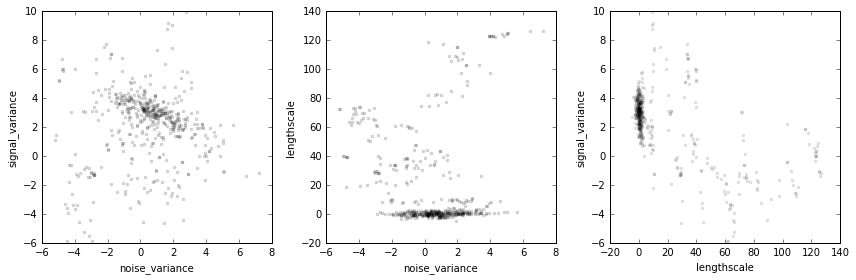

In [26]:
#Note. All these labels are wrong (or, most probably wrong). We need some machinery for labelling posterior samples!

f, axs = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
axs[0].plot(samples[:,0], samples[:,1], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')
axs[1].plot(samples[:,0], samples[:,2], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')
axs[2].plot(samples[:,2], samples[:,1], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

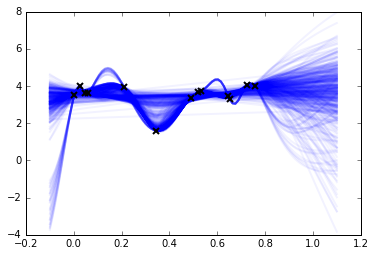

In [27]:
#an attempt to plot the function posterior
#Note that we should really sample the function values here, instead of just using the mean. 
#We are under-representing the uncertainty here. 
# TODO: get full_covariance of the predictions (predict_f only?)

plt.figure()

for s in samples:
    m.set_state(s)
    mean, _ = m.predict_y(xx)
    plt.plot(xx, mean, 'b', lw=2, alpha = 0.05)
    
plt.plot(X, Y, 'kx', mew=2)